In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import gaussian, threshold_otsu, threshold_multiotsu, sobel, threshold_sauvola
from skimage.morphology import remove_small_objects, disk, binary_closing
from scipy.ndimage import zoom, binary_dilation, binary_erosion, distance_transform_edt
from skimage.measure import label, regionprops
from skimage import io, exposure, color
from skimage import measure, morphology
from skimage import exposure
from czifile import imread
import cv2
import re
from matplotlib.ticker import MaxNLocator
import imageio.v2 as imageio  # or use `from imageio import imwrite` if you prefer
from huggingface_hub import hf_hub_download
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm
import numpy as np

c:\Users\sj1205\AppData\Local\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

class UNetPP(nn.Module):
    def __init__(self, n_classes, in_channels=1, base_ch=32):
        super().__init__()

        # Encoder
        self.conv00 = ConvBlock(in_channels, base_ch)
        self.pool0 = nn.MaxPool2d(2)

        self.conv10 = ConvBlock(base_ch, base_ch * 2)
        self.pool1 = nn.MaxPool2d(2)

        self.conv20 = ConvBlock(base_ch * 2, base_ch * 4)
        self.pool2 = nn.MaxPool2d(2)

        self.conv30 = ConvBlock(base_ch * 4, base_ch * 8)
        self.pool3 = nn.MaxPool2d(2)

        self.conv40 = ConvBlock(base_ch * 8, base_ch * 16)

        # Nested decoder
        self.up01 = ConvBlock(base_ch + base_ch * 2, base_ch)
        self.up11 = ConvBlock(base_ch * 2 + base_ch * 4, base_ch * 2)
        self.up21 = ConvBlock(base_ch * 4 + base_ch * 8, base_ch * 4)
        self.up31 = ConvBlock(base_ch * 8 + base_ch * 16, base_ch * 8)

        self.up02 = ConvBlock(base_ch * 2 + base_ch, base_ch)
        self.up12 = ConvBlock(base_ch * 4 + base_ch * 2, base_ch * 2)
        self.up22 = ConvBlock(base_ch * 8 + base_ch * 4, base_ch * 4)

        self.up03 = ConvBlock(base_ch * 2 + base_ch, base_ch)
        self.up13 = ConvBlock(base_ch * 4 + base_ch * 2, base_ch * 2)

        self.up04 = ConvBlock(base_ch * 2 + base_ch, base_ch)

        self.final = nn.Conv2d(base_ch, n_classes, kernel_size=1)

    def forward(self, x):
        x00 = self.conv00(x)
        x10 = self.conv10(self.pool0(x00))
        x20 = self.conv20(self.pool1(x10))
        x30 = self.conv30(self.pool2(x20))
        x40 = self.conv40(self.pool3(x30))

        x01 = self.up01(torch.cat([x00, F.interpolate(x10, x00.shape[2:])], dim=1))
        x11 = self.up11(torch.cat([x10, F.interpolate(x20, x10.shape[2:])], dim=1))
        x21 = self.up21(torch.cat([x20, F.interpolate(x30, x20.shape[2:])], dim=1))
        x31 = self.up31(torch.cat([x30, F.interpolate(x40, x30.shape[2:])], dim=1))

        x02 = self.up02(torch.cat([x01, F.interpolate(x11, x01.shape[2:])], dim=1))
        x12 = self.up12(torch.cat([x11, F.interpolate(x21, x11.shape[2:])], dim=1))
        x22 = self.up22(torch.cat([x21, F.interpolate(x31, x21.shape[2:])], dim=1))

        x03 = self.up03(torch.cat([x02, F.interpolate(x12, x02.shape[2:])], dim=1))
        x13 = self.up13(torch.cat([x12, F.interpolate(x22, x12.shape[2:])], dim=1))

        x04 = self.up04(torch.cat([x03, F.interpolate(x13, x03.shape[2:])], dim=1))

        return self.final(x04)

In [3]:
model_path = hf_hub_download(repo_id="sunny17347/machine_learning_models", filename="unetpp_trained_7_8_2025.pth")

model = UNetPP(n_classes=2)  # or whatever n_classes you trained with
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

c:\Users\sj1205\AppData\Local\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sj1205\.cache\huggingface\hub\models--sunny17347--machine_learning_models. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


UNetPP(
  (conv00): ConvBlock(
    (block): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv10): ConvBlock(
    (block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )

In [4]:
def display_two_images(image1, image2, title1, title2, path):
    """Display two images side-by-side with smaller title font."""
    filename = os.path.basename(path)  # Extract final part of path

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image1, cmap='gray' if image1.ndim == 2 else None)
    axes[0].set_title(f"{filename} {title1}", fontsize=10)
    axes[0].axis('off')

    axes[1].imshow(image2, cmap='gray' if image2.ndim == 2 else None)
    axes[1].set_title(f"{filename} {title2}", fontsize=10)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


def display_image(image, path, type):
    """Display the image."""
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{path} {type}")
    plt.show()


def extract_image_paths(folder):
    """Extract all image file paths from the specified folder."""
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

def read_image(image_path):
    """Read the LSM image from the specified path."""
    return imread(image_path)

def extract_channels(image: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Extract green and red channels from the squeezed image (shape: [Z, C, H, W]).""" 
    return image[0], image[1]

def load_16bit_image(image_path):
    image = Image.open(image_path)  # mode is 'I;16'
    np_image = np.array(image).astype(np.float32)

    # Normalize to [0, 1] using max possible 16-bit value
    np_image /= 65535.0

    # Add channel dimension and convert to tensor
    tensor = torch.from_numpy(np_image).unsqueeze(0)  # shape: (1, H, W)
    return tensor

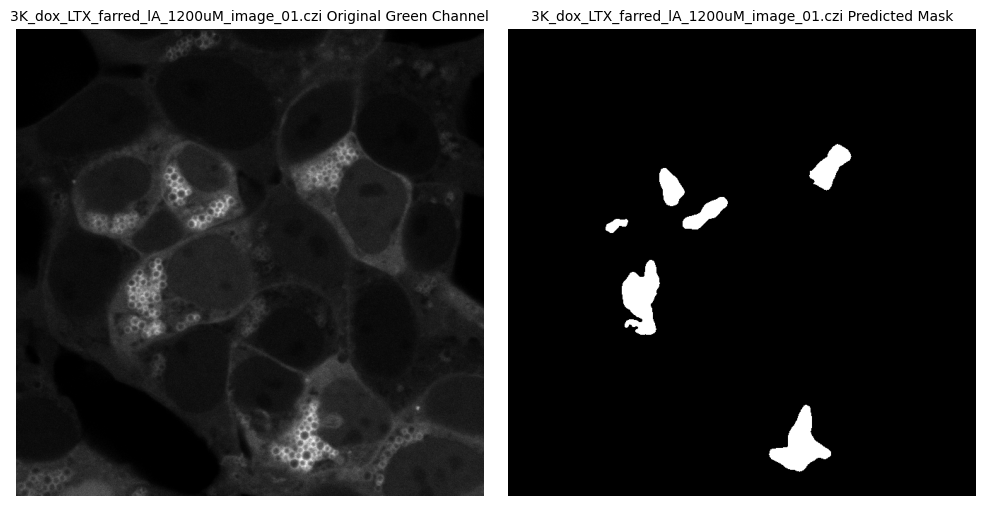

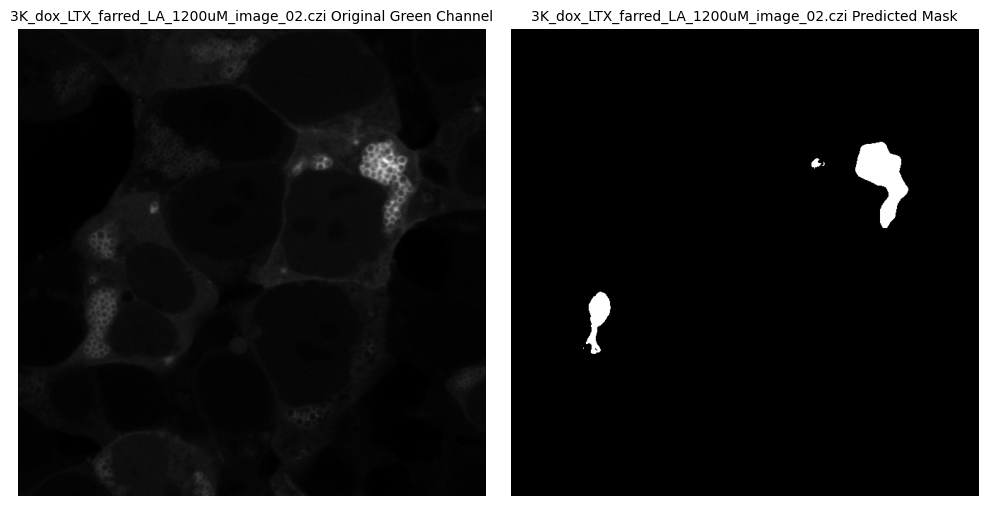

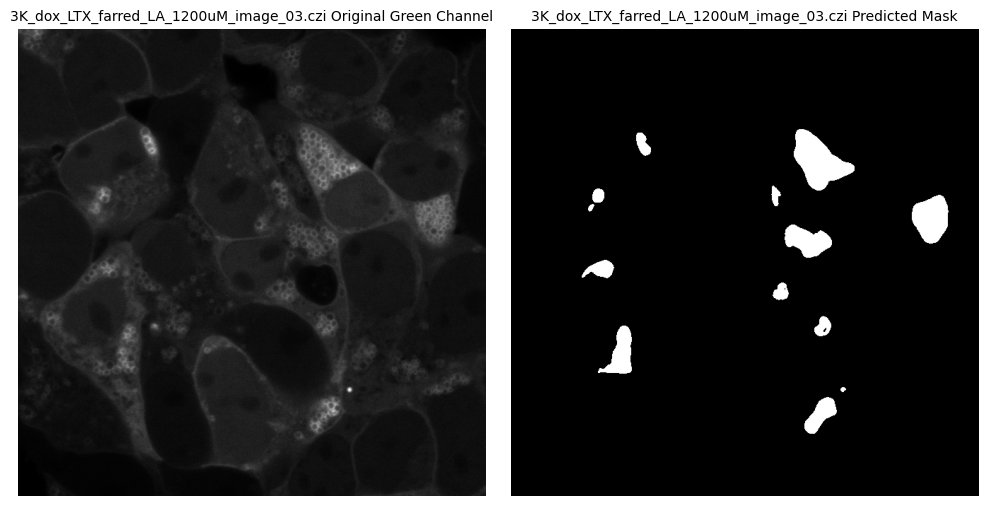

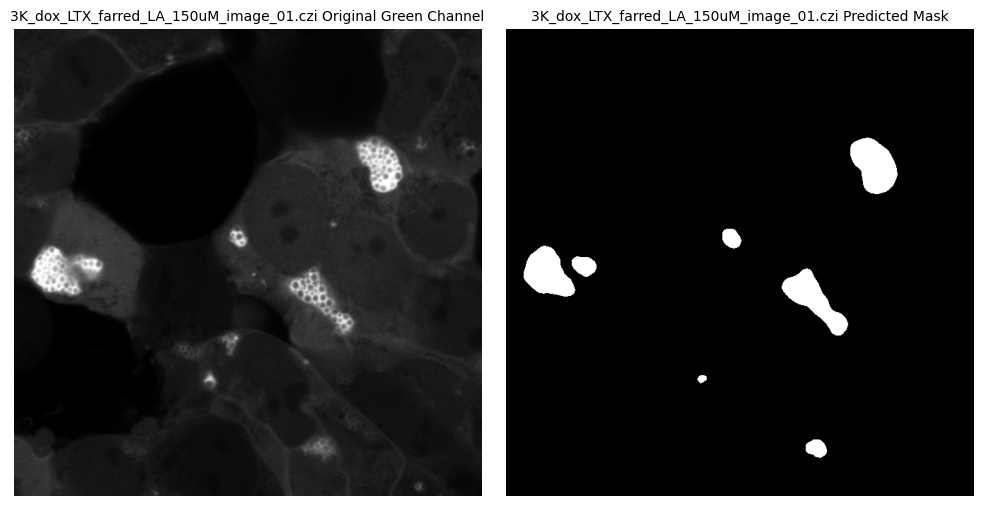

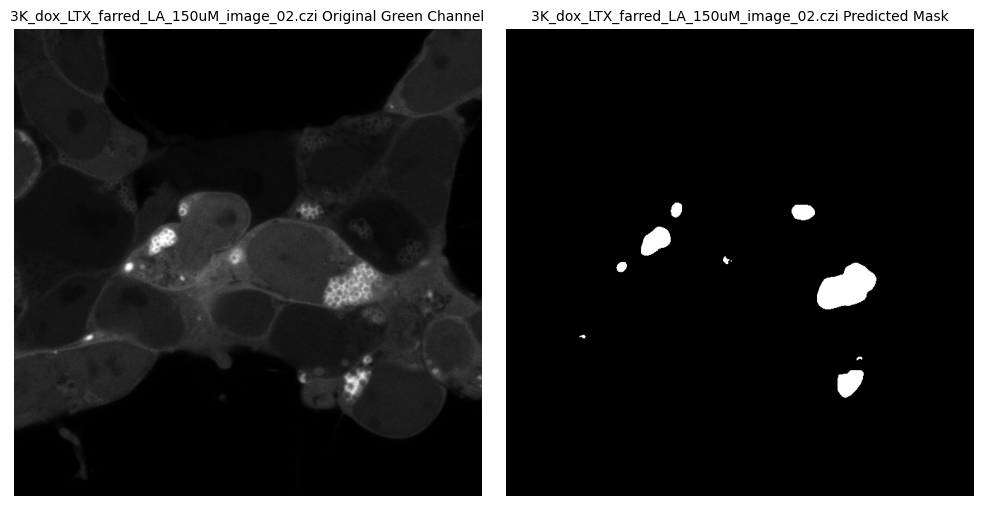

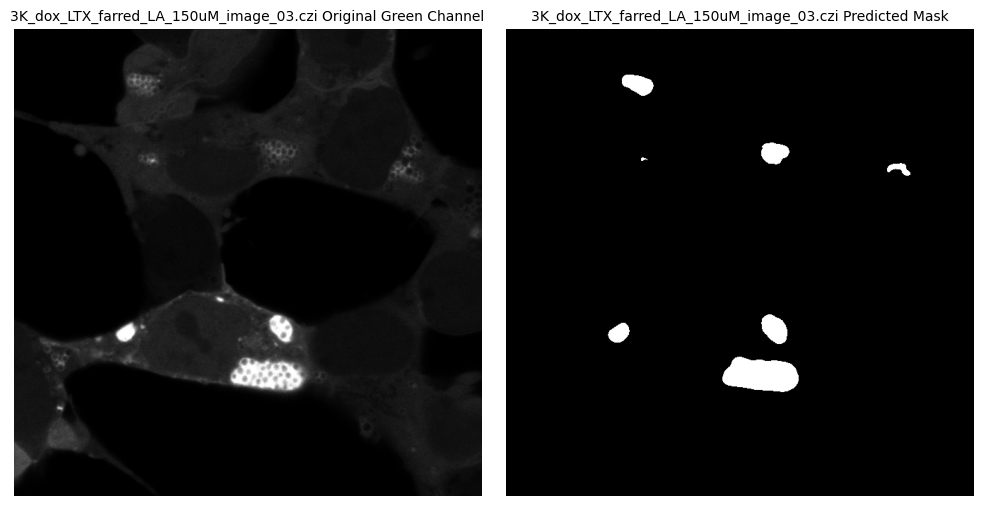

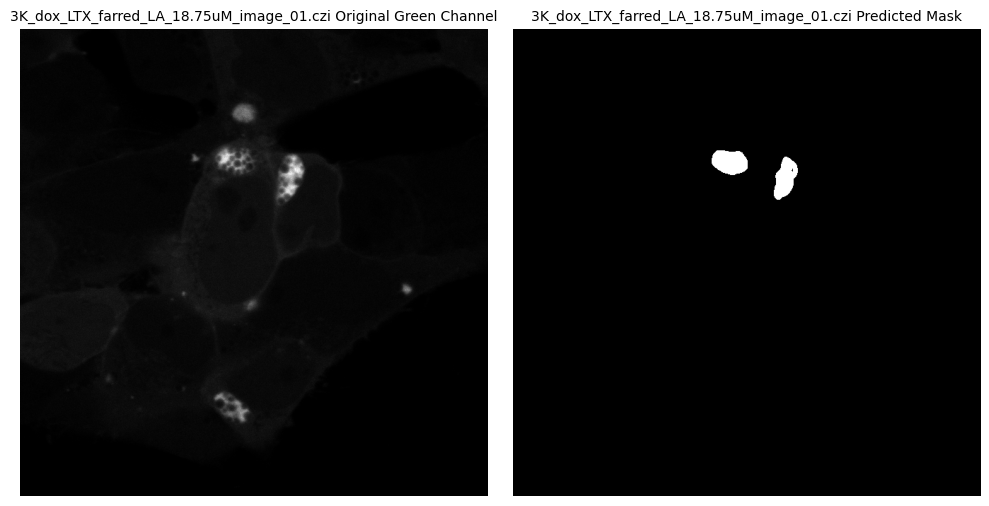

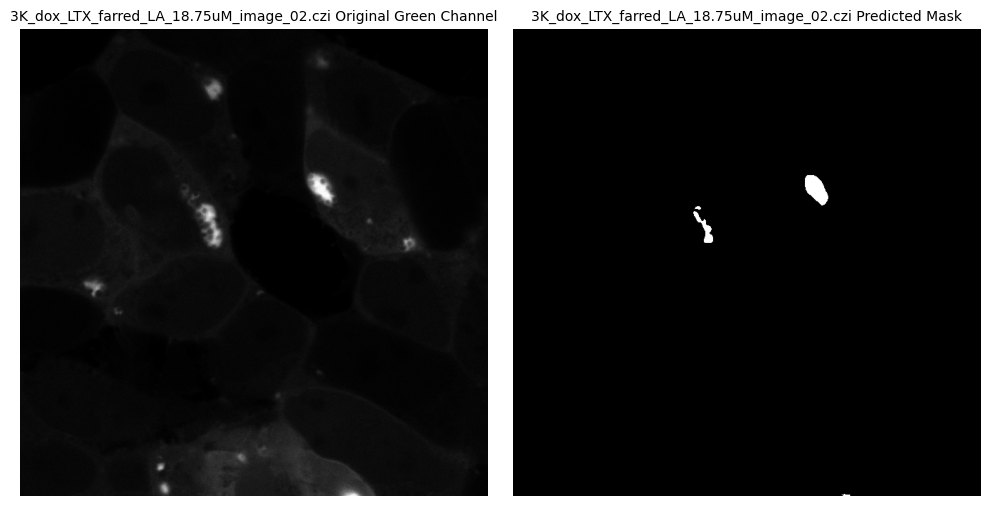

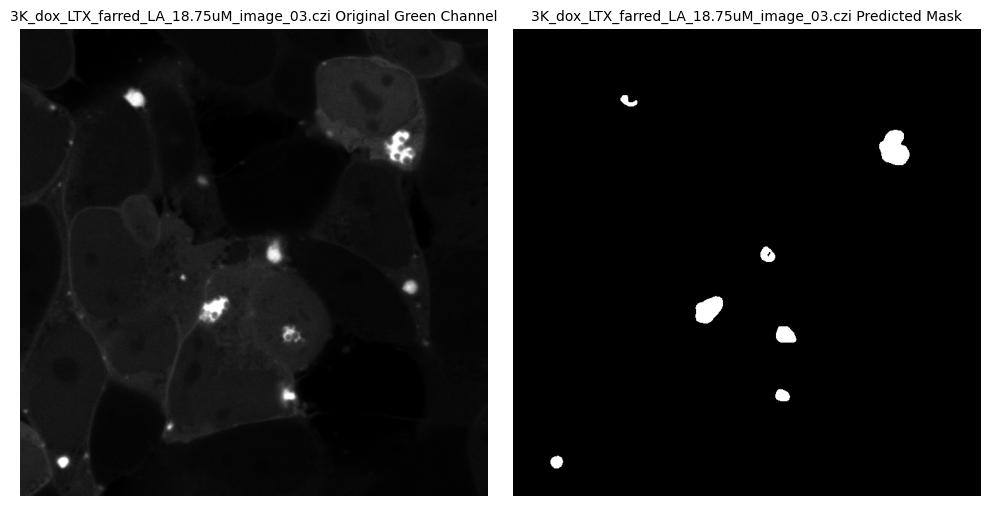

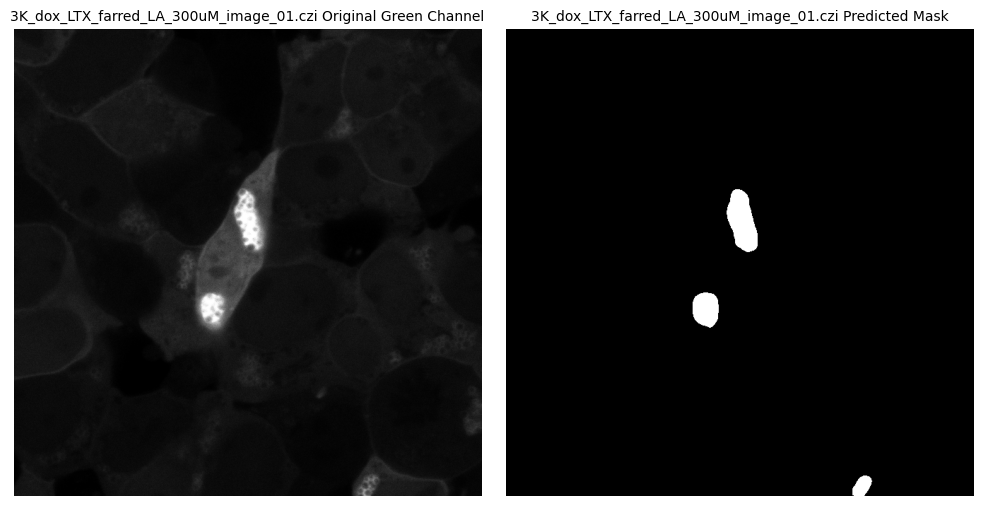

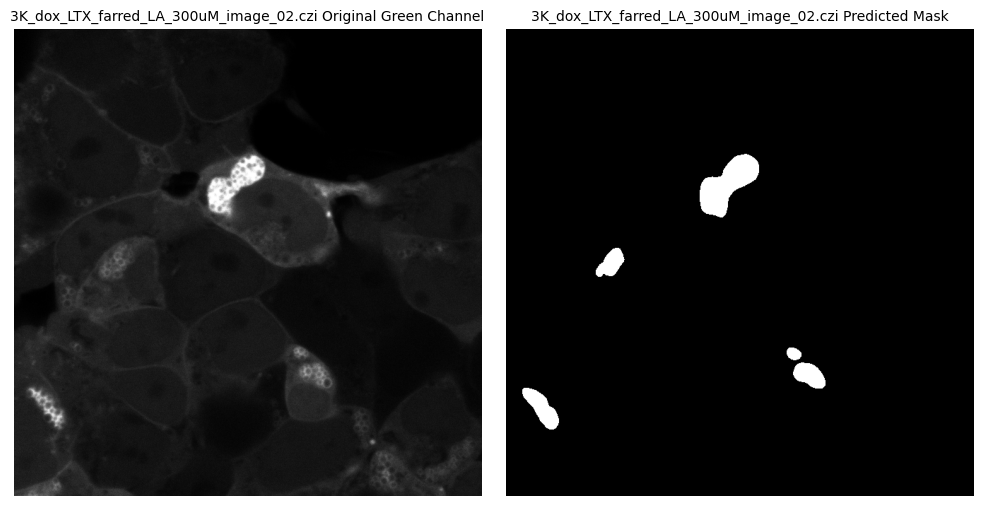

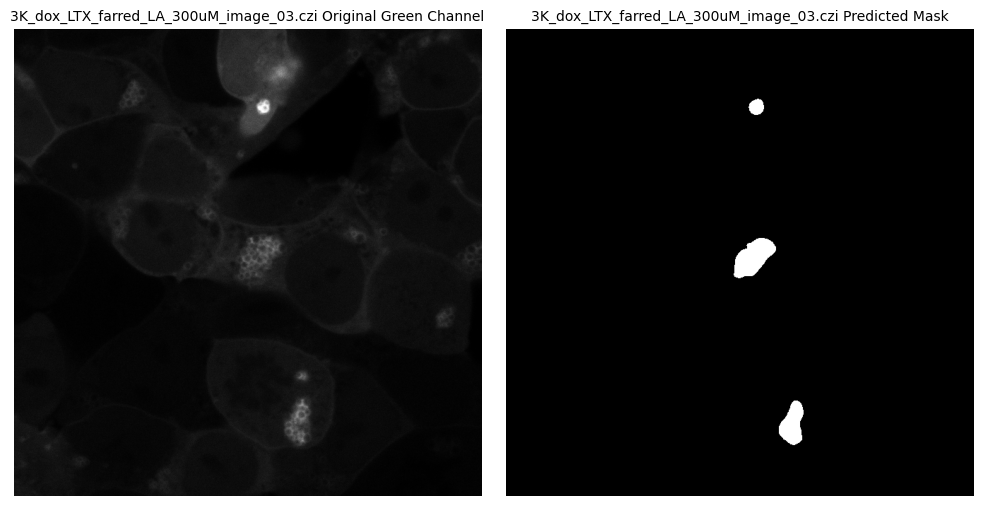

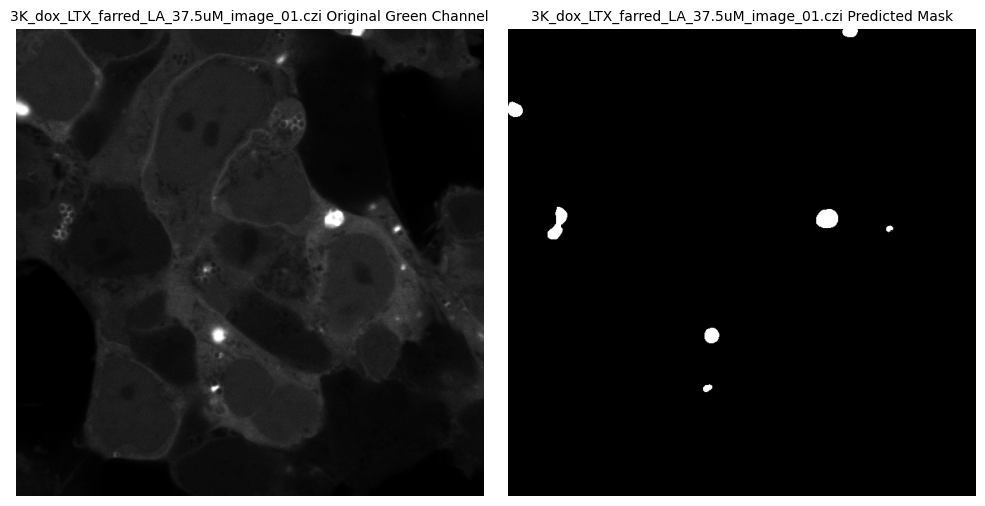

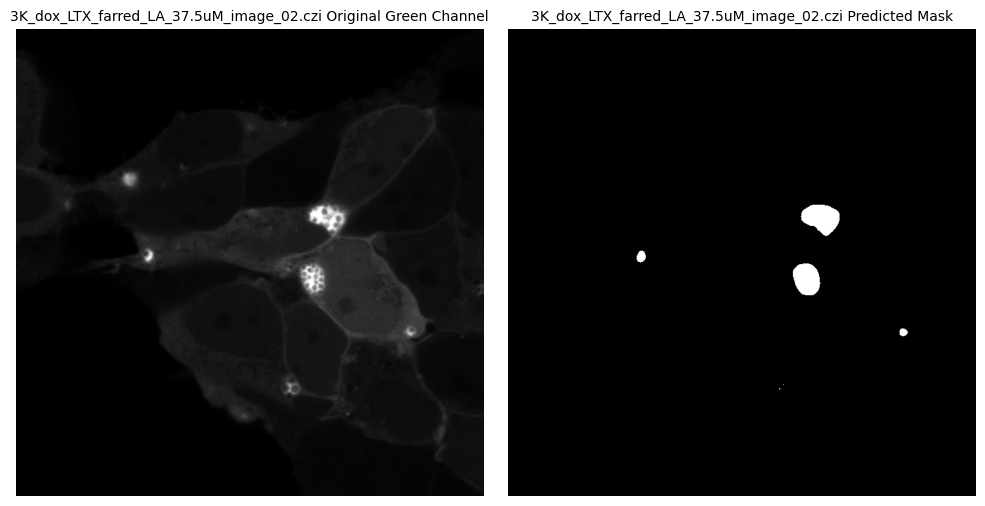

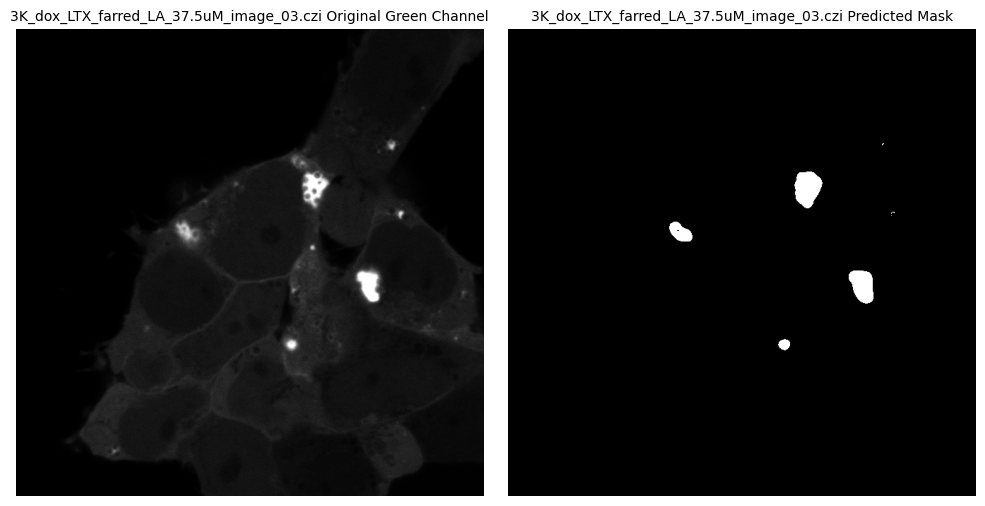

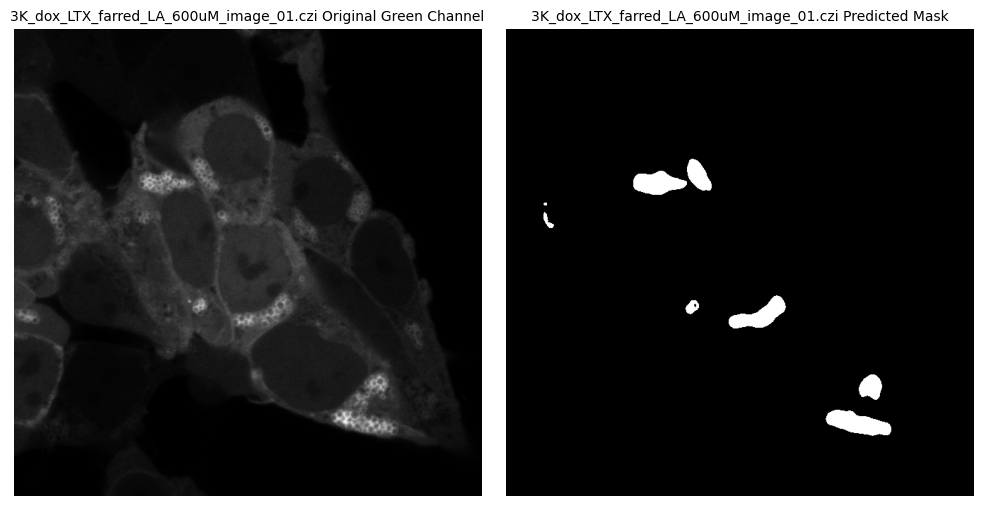

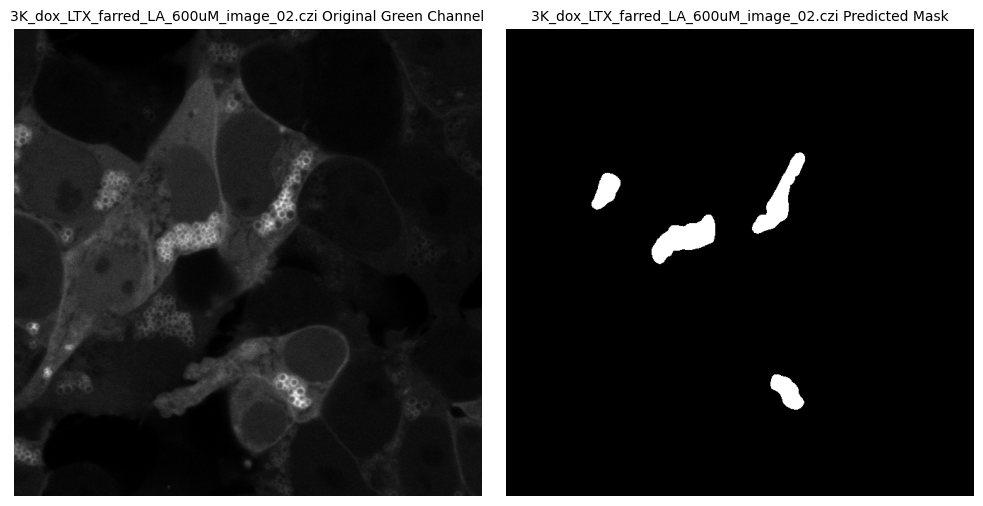

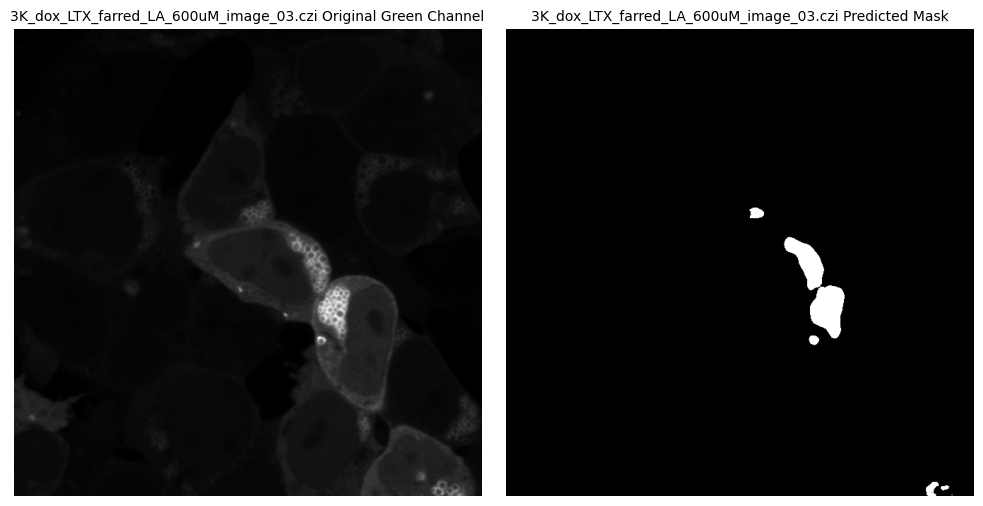

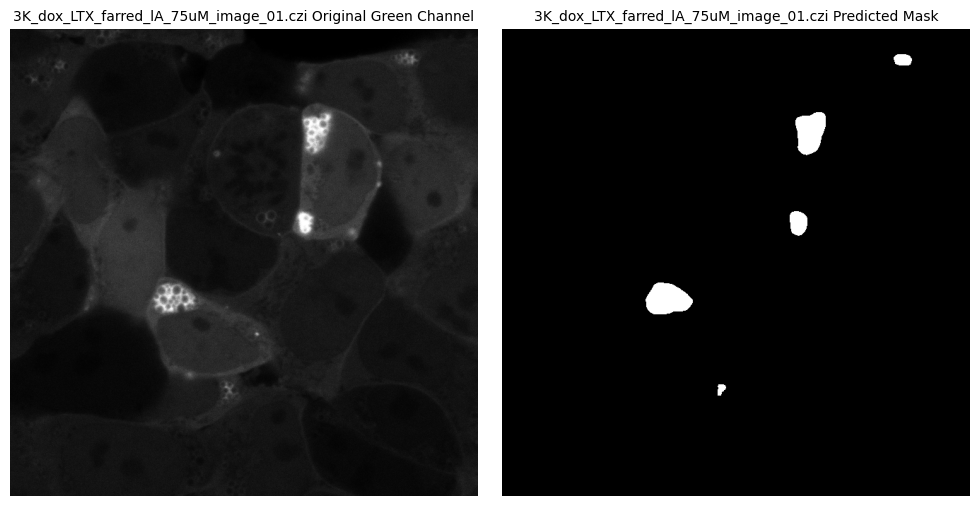

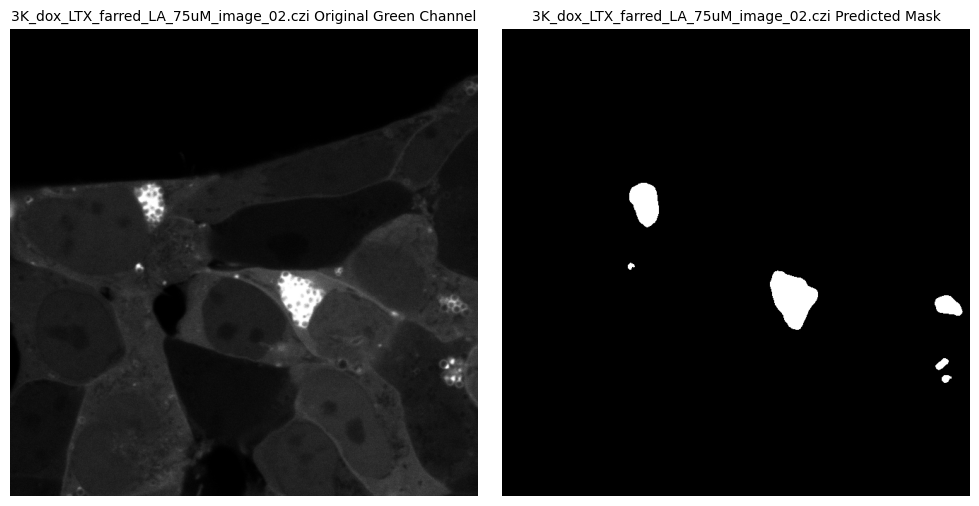

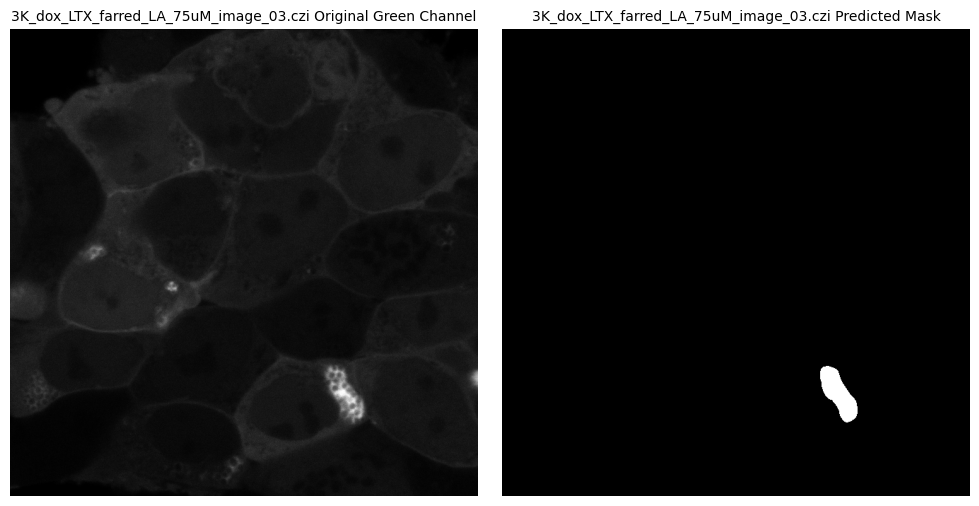

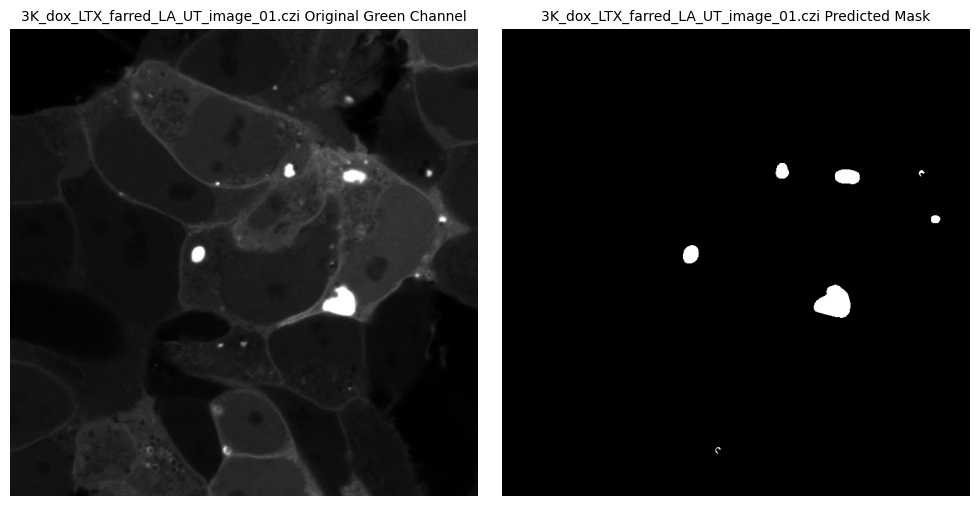

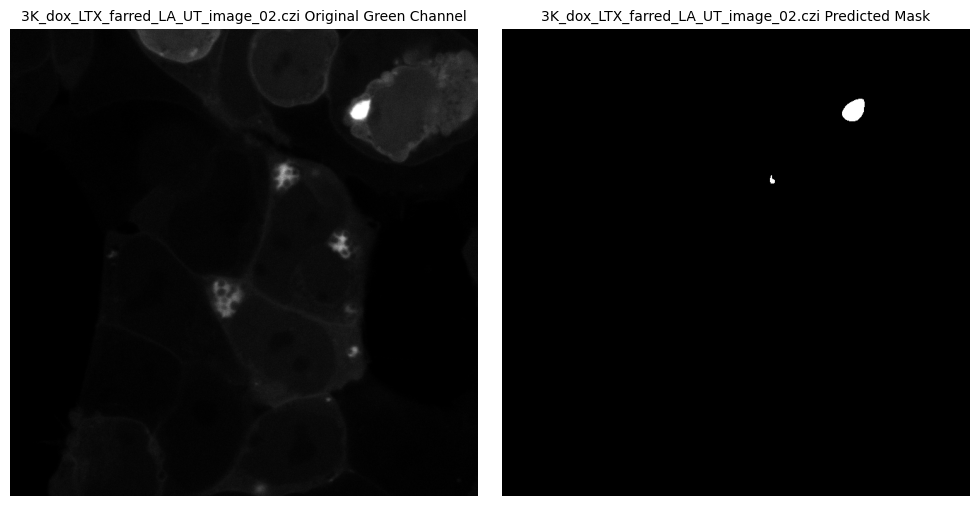

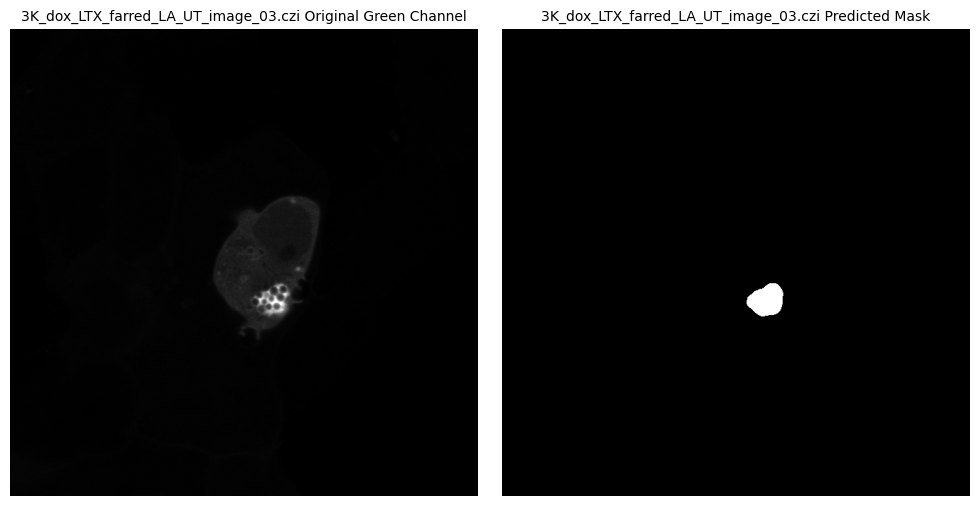

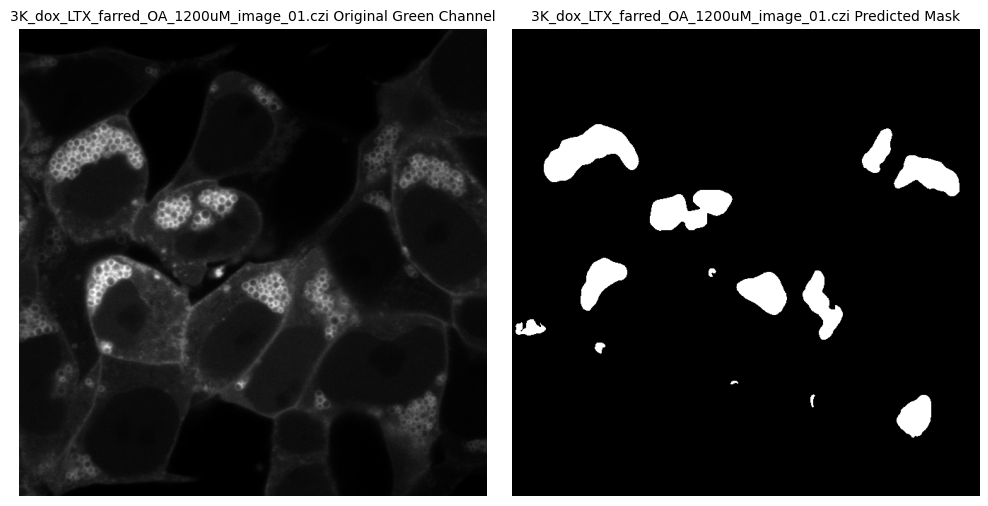

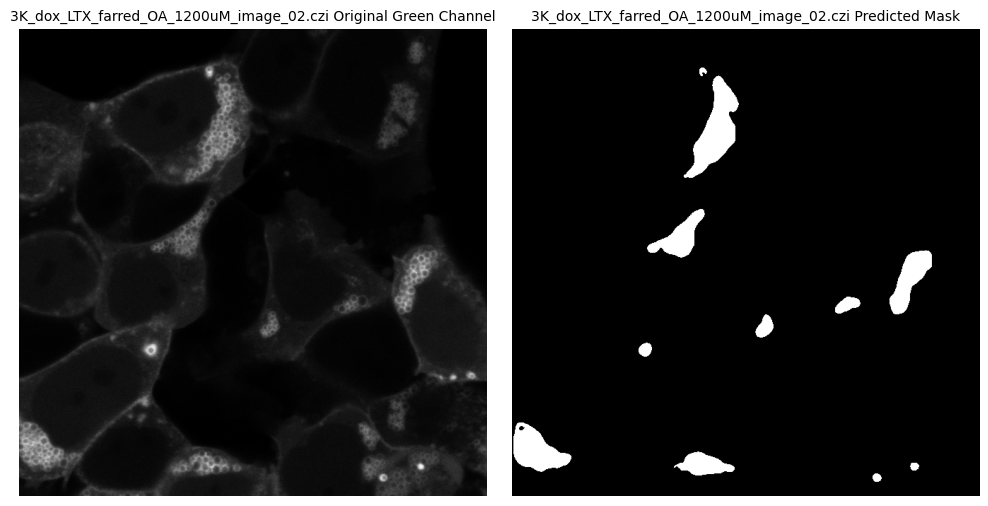

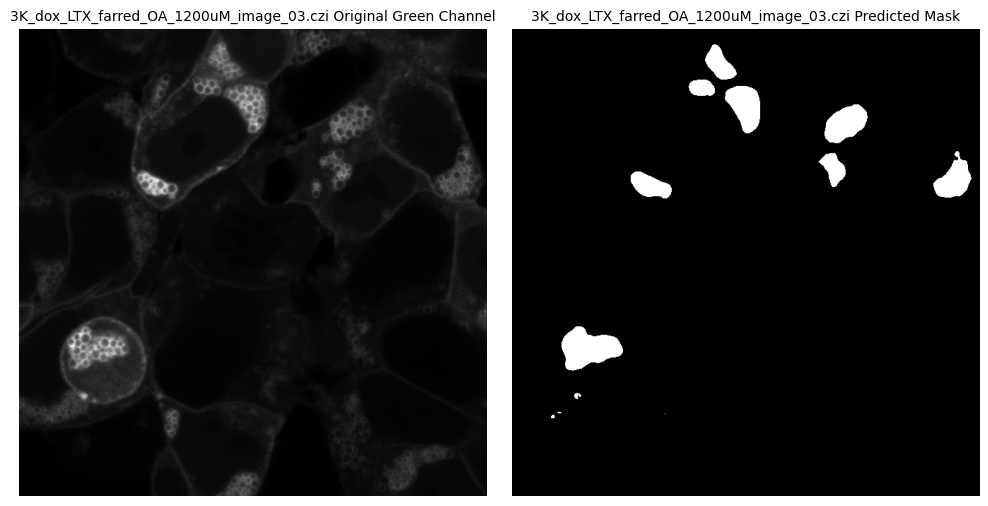

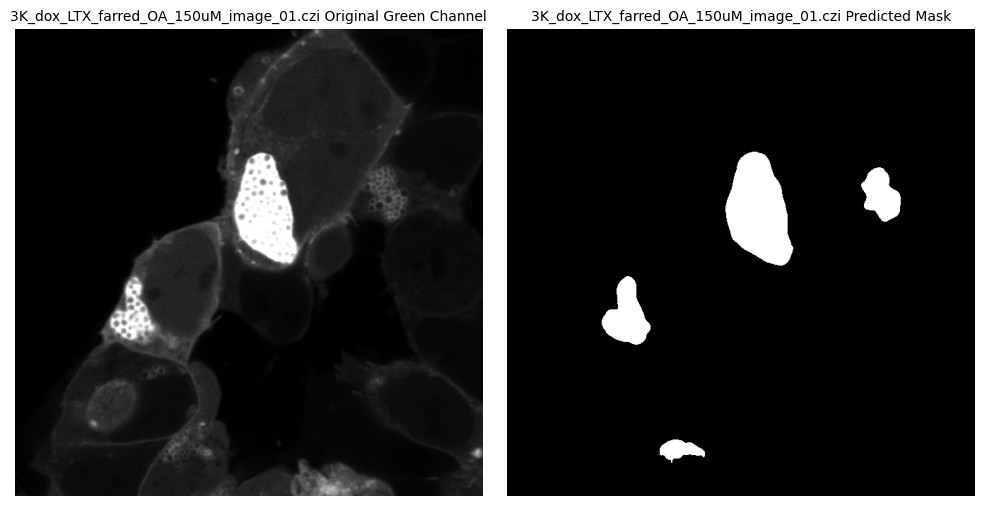

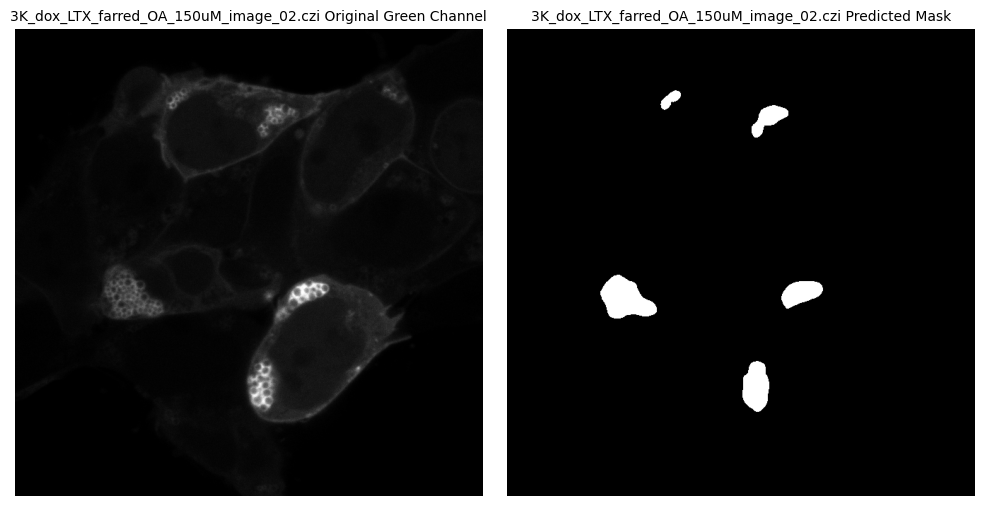

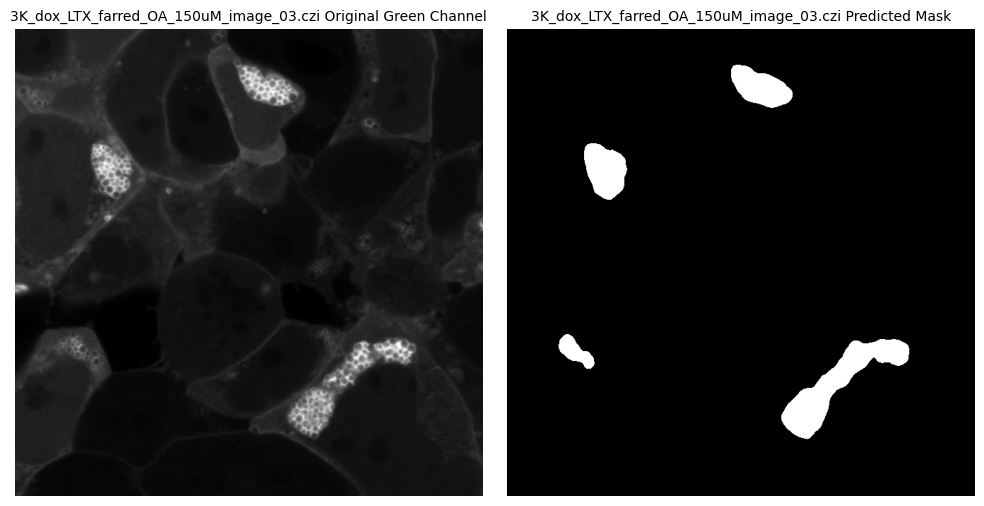

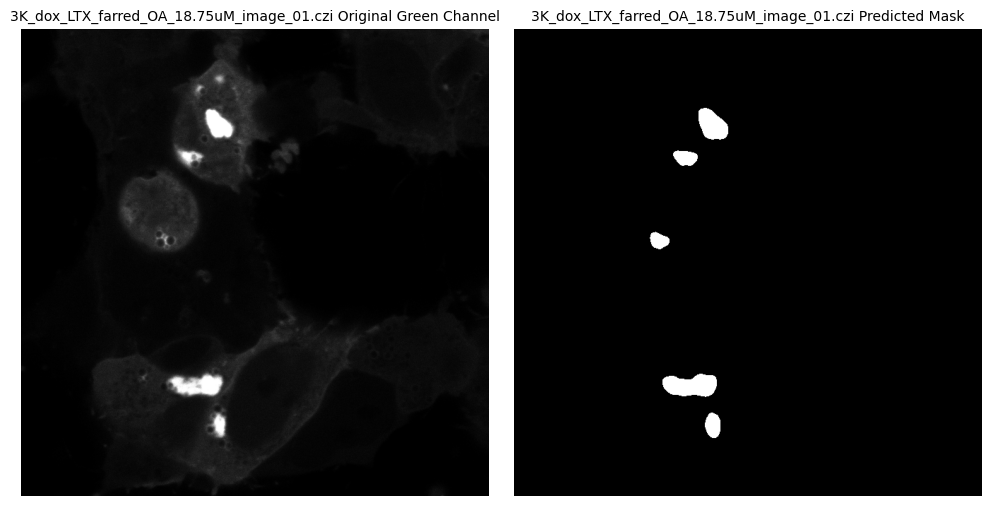

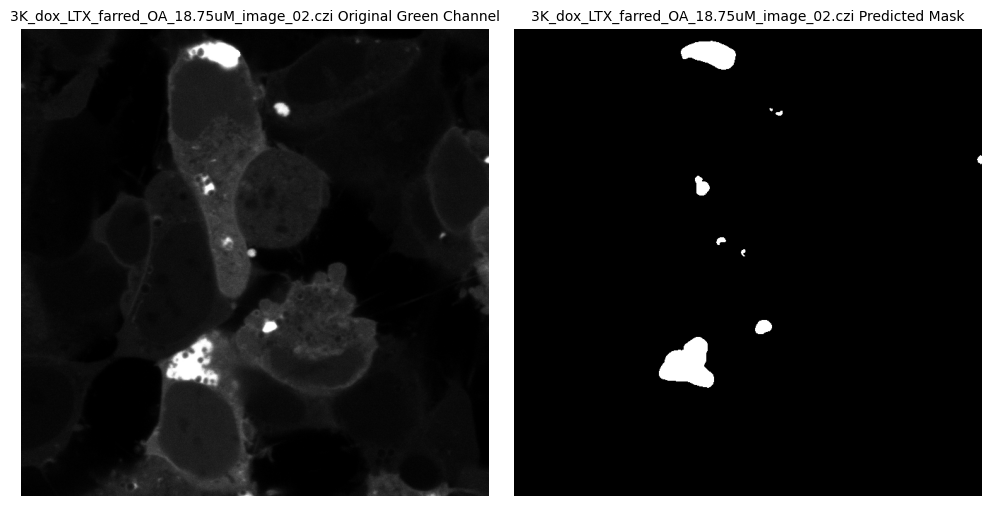

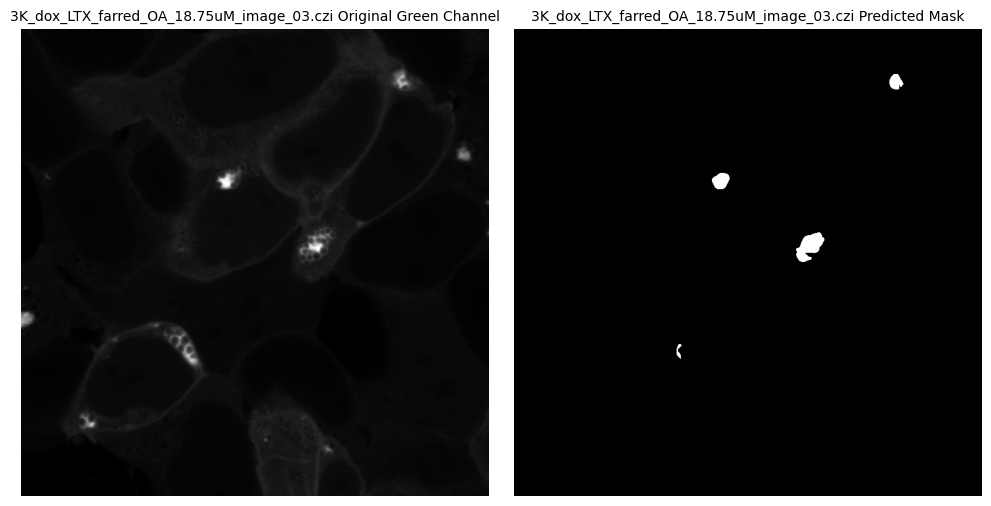

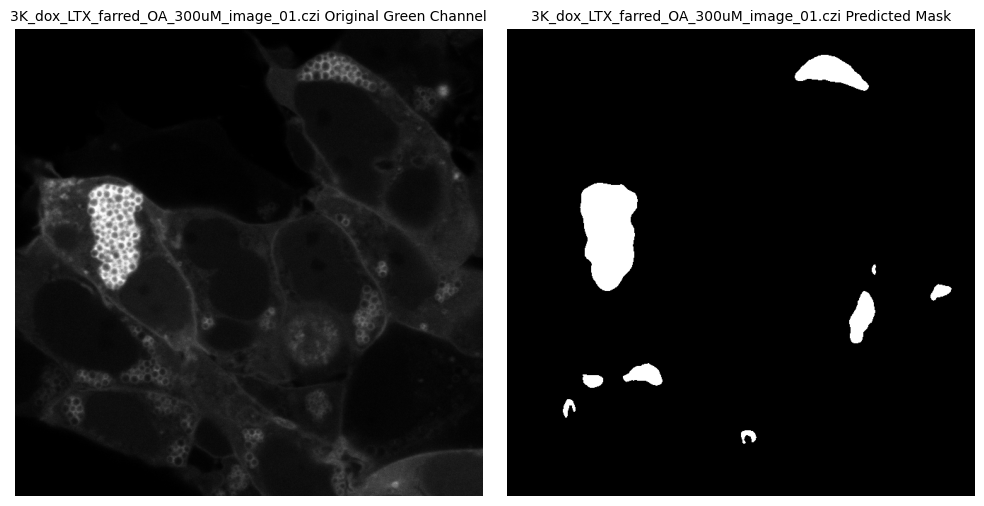

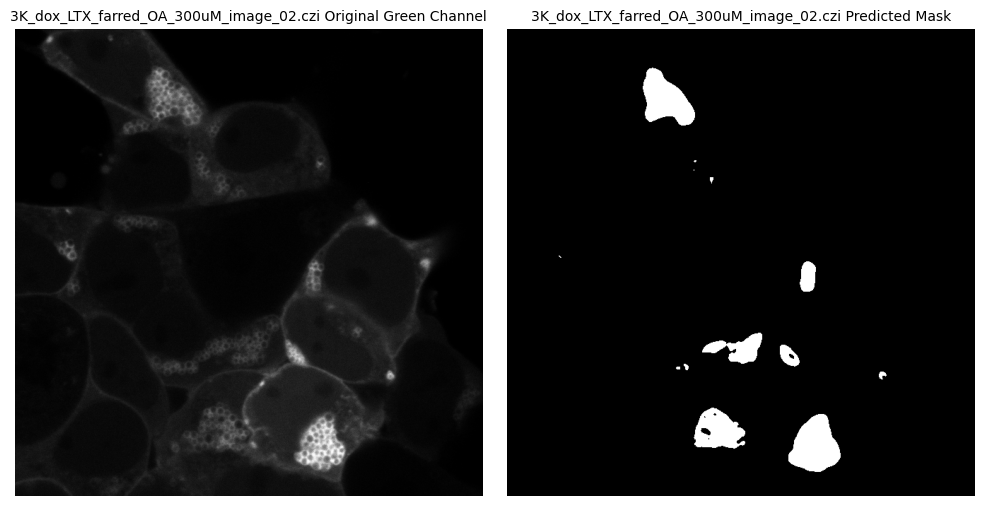

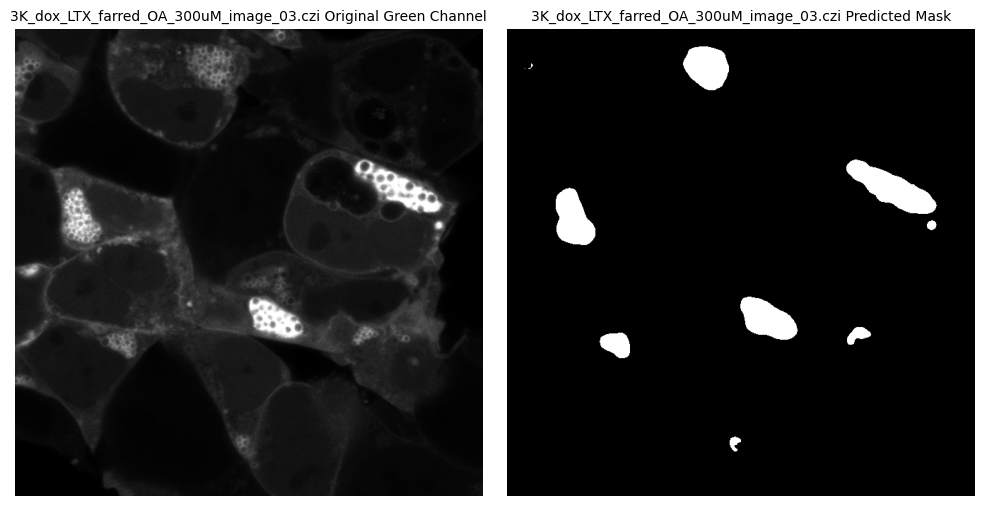

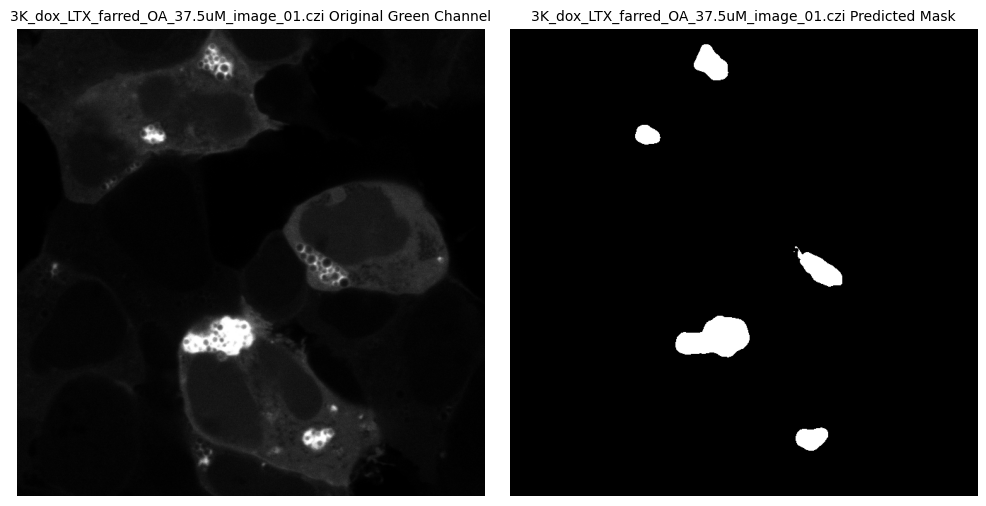

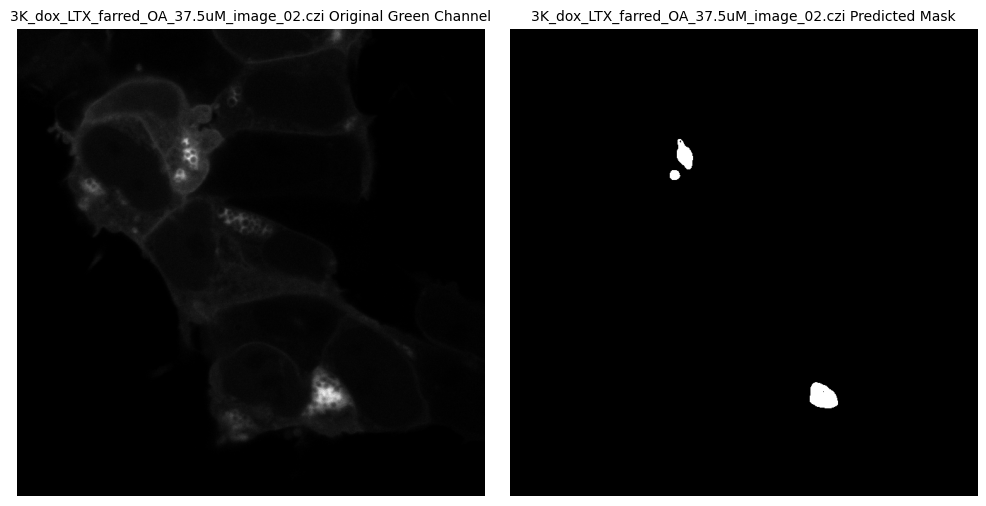

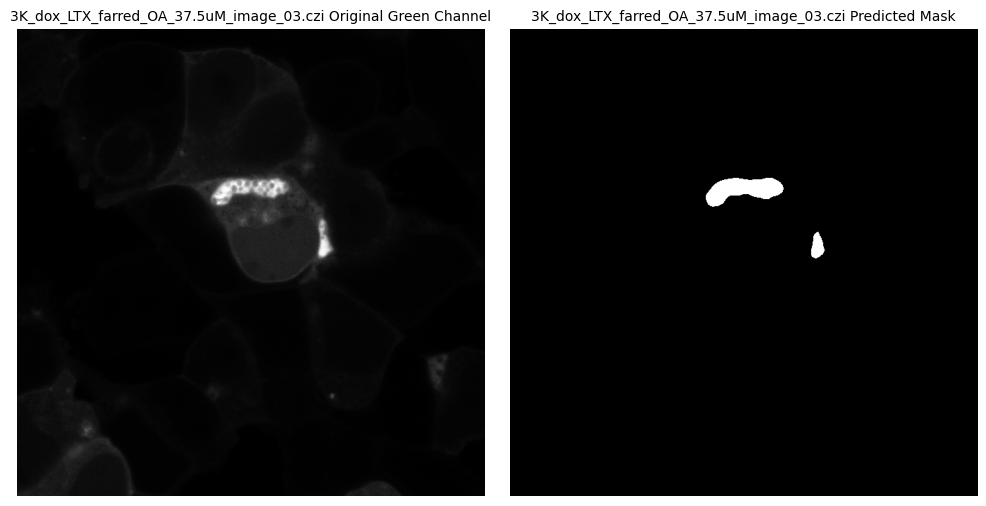

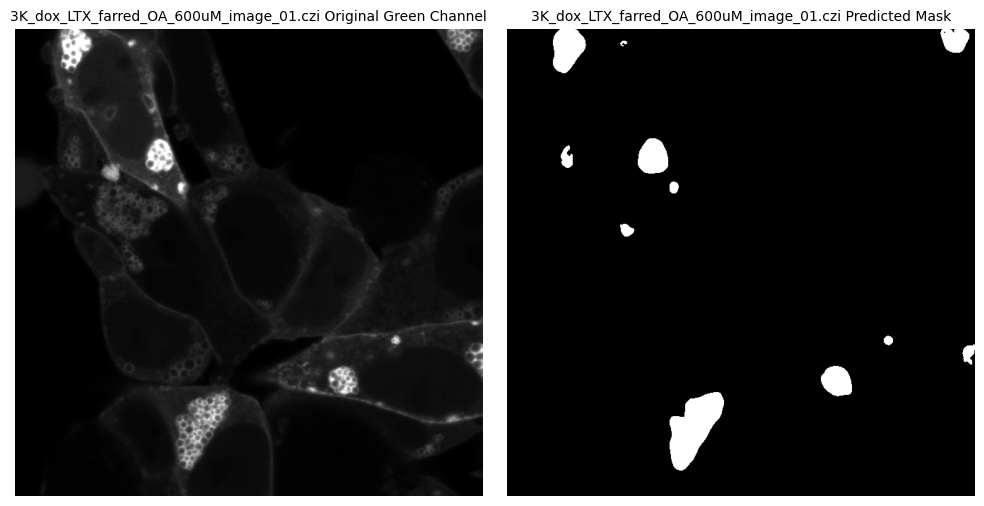

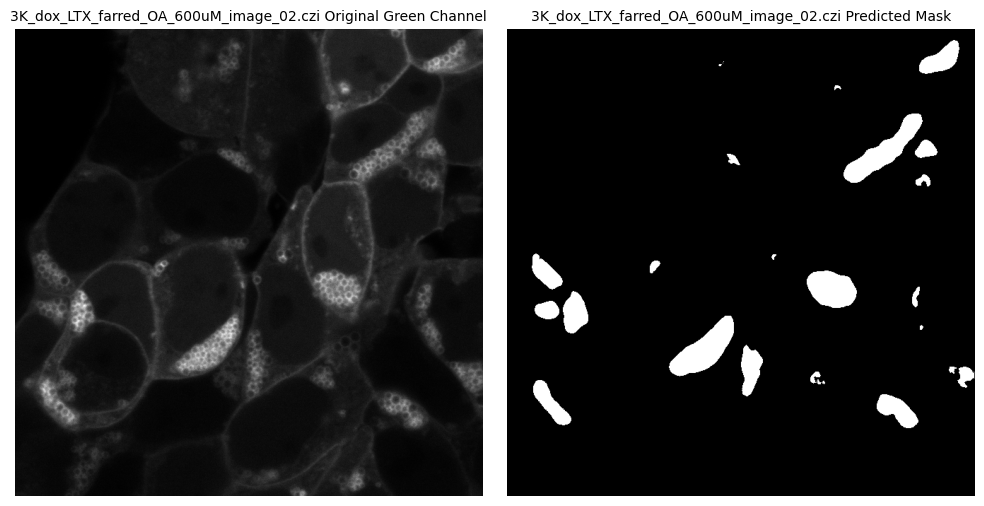

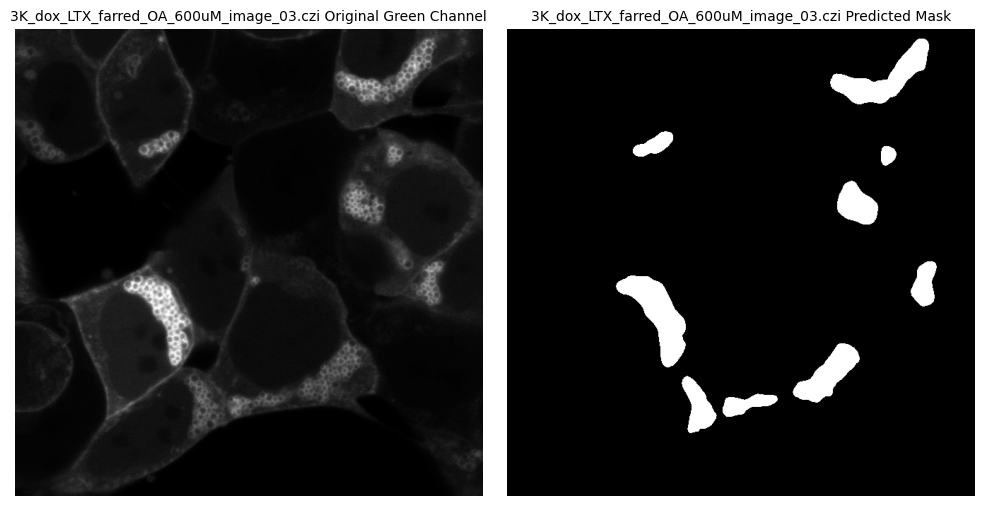

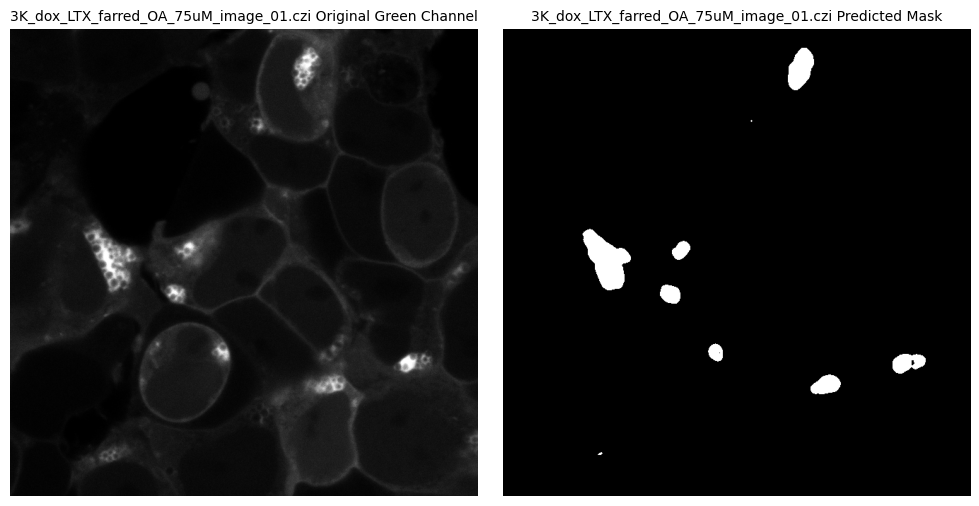

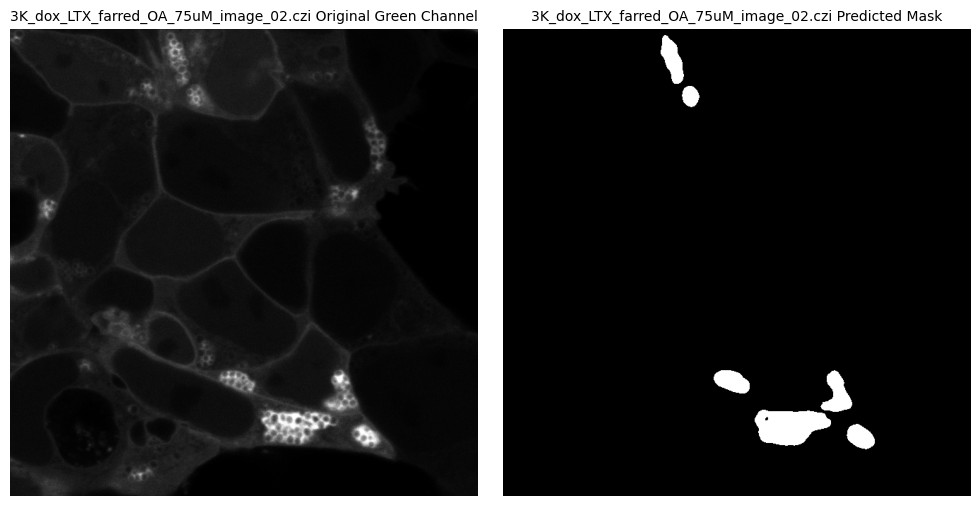

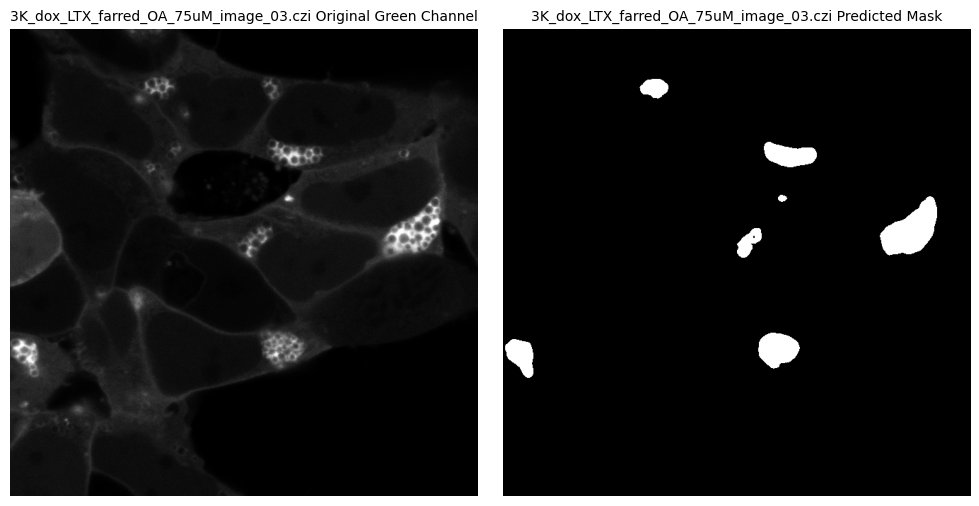

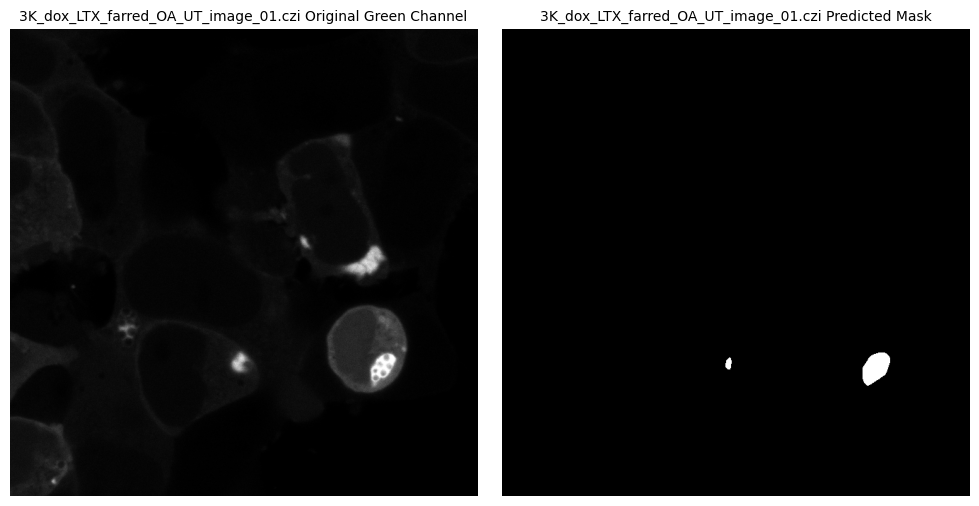

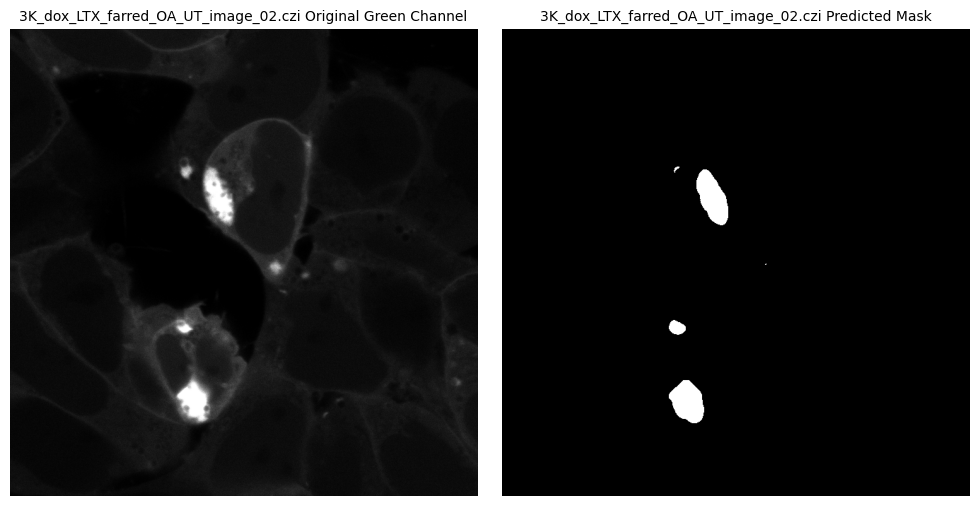

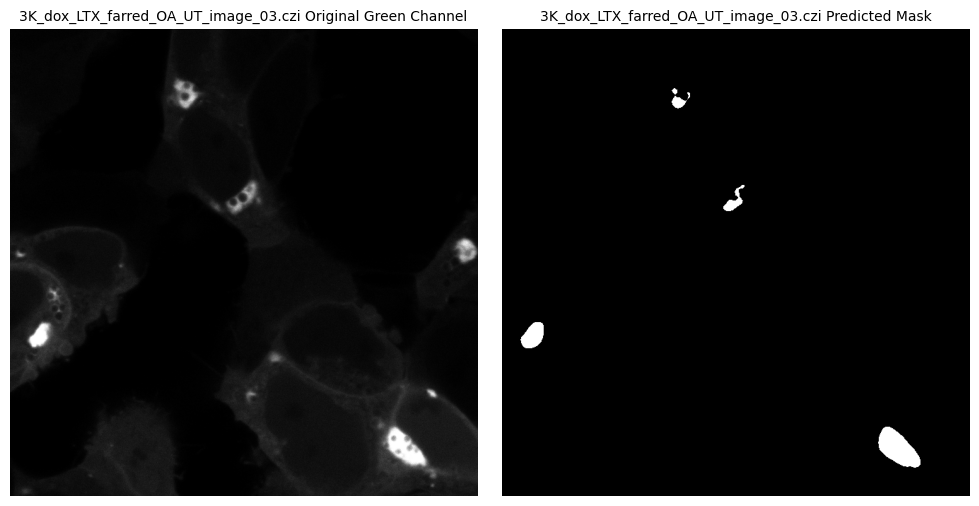

In [5]:
def main(image_folder):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    output_dir = "images/unetpp_pred"
    os.makedirs(output_dir, exist_ok=True)

    images_to_analyze = extract_image_paths(image_folder)

    for path in images_to_analyze:
        image = read_image(path)
        image_squeezed = np.squeeze(image) 

        red, green = extract_channels(image_squeezed)

        green_np_image = np.array(green).astype(np.float32)
        green_np_image /= 65535.0

        tensor = torch.from_numpy(green_np_image).unsqueeze(0)  # shape: (1, H, W)
        input_tensor = tensor.unsqueeze(0).to(device)  # shape: (1, 1, H, W)

        with torch.no_grad():
            output = model(input_tensor)
            pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()

        image_np = tensor.squeeze(0).numpy()

        display_two_images(
            image1=image_np,
            image2=pred,
            title1="Original Green Channel",
            title2="Predicted Mask",
            path=path
        )

        # Convert and save prediction
        pred_uint8 = pred.astype(np.uint8) * 255  # For binary mask
        filename = os.path.splitext(os.path.basename(path))[0]

        for prefix in ["3K_dox_LTX_farred_"]:
            if filename.startswith(prefix):
                filename = filename[len(prefix):]
                break
        save_path = os.path.join(output_dir, f"{filename}.png")
        imageio.imwrite(save_path, pred_uint8)

if __name__ == "__main__":
    image_folder = 'images/test_images'
    main(image_folder)